In [1]:
import os
import re
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten,Dense,Embedding
from keras import models, layers, optimizers, losses, metrics
from keras.layers import Dropout
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.convolutional  import  Convolution1D, MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import LambdaCallback
tok = Tokenizer()

Using TensorFlow backend.


# Data Exploration and Pre-processing

In [3]:
train_pos=[]
train_neg=[]
test_pos=[]
test_neg=[]

train_test_split

In [4]:
#imput data and make train_test_split
def train_test_split(file_root):
    train = []
    test = []
    for file_root, _, file in os.walk(file_root):
        for f in file:
                index = int(re.findall("\d+", f)[0])
                file_path = os.path.join(file_root, f)
                name = os.path.split(file_root)[-1]
                if (index > 699):
                    test.append(file_path)
                else:
                    train.append(file_path)
    return train, test

Remove the punctuation and numbers

In [5]:
#remove the punctuation
def remove(text):
    remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(remove_chars, '', text)

In [6]:
train_pos,test_pos=train_test_split('../Data/pos')
train_neg,test_neg=train_test_split('../Data/neg')

In [7]:
#remove \n and combine all the string
stri=[]#the box to hold all the words

In [8]:
def remove_combine(data):
    for i in range(0,len(data)):
        f=open(data[i],'r')
        st=f.read()
        f.close()
        st=remove(st)
        st=st.replace('\n','').replace('\r','')
        stri.append(st)

Count the number of unique words

In [9]:
#combine
remove_combine(train_pos)
remove_combine(test_pos)
remove_combine(train_neg)
remove_combine(test_neg)
#print(stri)
tok.fit_on_texts(stri)
#print(tok.word_counts)
all_words=len(tok.word_counts)
print('All words is',all_words)

All words is 46830


Average review length and the standard deviation

In [10]:
#show result
review_len=[]
for a in range(0,len(stri)):
    st_new=stri[a]
    st_new=st_new.split()
    review_len.append(len(st_new))
df_review_len=pd.DataFrame(review_len,columns=['length'])
print('The average length of review is',df_review_len.mean().values[0])
print('The std of review is',df_review_len.std().values[0])

The average length of review is 644.361
The std of review is 285.0598064014157


Plot the histogram

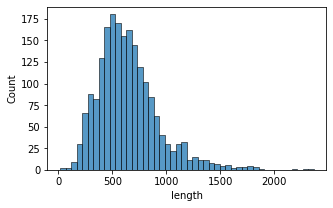

In [11]:
plt.figure(figsize=(5,3))
sns.histplot(data=df_review_len, x='length')
plt.show()

Select a review length L and Truncate reviews 

In [12]:
#data transfrom
data_trans=tok.texts_to_sequences(stri)
df_review_len_sort=df_review_len.sort_values(by='length')
max_num=df_review_len_sort.iloc[int(len(review_len)*0.9),:].values[0] #choose max_length
data_trans_true=pad_sequences(data_trans,maxlen=max_num,padding ='post',truncating='post')
print(data_trans_true)

[[  98 2272 8121 ...    0    0    0]
 [  61   65 1967 ...    0    0    0]
 [   1   66    4 ...    0    0    0]
 ...
 [1385 2280    6 ...    0    0    0]
 [ 152 4698   30 ...    0    0    0]
 [  23  685    5 ...    0    0    0]]


In [13]:
#train_test_split
df_raw_data=pd.DataFrame(data_trans_true)
x_train1=df_raw_data.iloc[:700,:]
x_test1=df_raw_data.iloc[700:1000,:]
x_train2=df_raw_data.iloc[1000:1700,:]
x_test2=df_raw_data.iloc[1700:,:]
x_train=pd.concat([x_train1,x_train2])
x_test=pd.concat([x_test1,x_test2])
x_train=pd.DataFrame(x_train.values)
x_test=pd.DataFrame(x_test.values)
x_train[x_train>=5000]=0
x_test[x_test>=5000]=0
y_train1=list(1 for i in range(1,701))
y_train2=list(-1 for i in range(1,701))
y_train=y_train1+y_train2
y_test1=list(1 for i in range(1,301))
y_test2=list(-1 for i in range(1,301))
y_test=y_test1+y_test2

In [14]:
#mix up train_data
indices=np.arange(x_train.shape[0])
np.random.shuffle(indices)
y_train=pd.DataFrame(y_train)
x_train=x_train.loc[indices]
y_train=y_train.loc[indices]
x_train=x_train.values
x_test=x_test.values

# Multi-Layer Perceptron

In [15]:
#mlp
def mlp(opt='adam'):
    model = Sequential()
    model.add(Embedding(5001, 32, input_length=max_num))
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def acc_result(x_tr,x_te,y_tr,y_te,classifier,num_epochs):
    mlp_model = KerasClassifier(build_fn=classifier, epochs=num_epochs, batch_size=10)
    mlp_model.fit(x_tr,y_tr)
    y_train_predict_mlp = mlp_model.predict(x_tr)
    y_test_predict_mlp = mlp_model.predict(x_te)
    train_acc = accuracy_score(y_tr,y_train_predict_mlp)
    test_acc = accuracy_score(y_te,y_test_predict_mlp)
    return train_acc, test_acc,y_train_predict_mlp,y_test_predict_mlp

In [19]:
#print the result of mlp
mlp_train_acc,mlp_test_acc,y_p_train_mlp,y_p_test_mlp= acc_result(x_train,x_test,y_train,y_test,mlp,2)
print('Using mlp models, the train set accuracy is:{}, the test set accuracy is {}.'.
      format(round(mlp_train_acc,4),round(mlp_test_acc,4)))

Epoch 1/2
1400/1400 [==============================] - 9s 6ms/step - loss: 0.7076 - accuracy: 0.4793
Epoch 2/2
1400/1400 [==============================] - 8s 6ms/step - loss: 0.6865 - accuracy: 0.5371
Using mlp models, the train set accuracy is:0.6836, the test set accuracy is 0.5617.


# One-Dimensional Convolutional Neural Network:

In [26]:
#CNN
def CNN(opt='adam'):
    model = Sequential()
    model.add(Embedding(5001, 32, input_length=max_num))
    model.add(Convolution1D(32,3,activation='relu'))
    model.add(MaxPooling1D(strides=2,pool_size=2))
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
cnn_train_acc,cnn_test_acc,y_p_train_cnn,y_p_test_cnn=acc_result(x_train,x_test,y_train,y_test,CNN,2)
print('Using cnn models, the train accuracy is:{}, the test accuracy is {}.'.format(round(cnn_train_acc,4),round(cnn_test_acc,4)))

Epoch 1/2
1400/1400 [==============================] - 9s 7ms/step - loss: 0.6966 - accuracy: 0.5014
Epoch 2/2
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6922 - accuracy: 0.5293
Using cnn models, the train accuracy is:0.6521, the test accuracy is 0.5633.


# Long Short-Term Memory Recurrent Neural Network

In [28]:
#LSTM
def LSTM_model(opt='adam'):
    model = Sequential()
    model.add(Embedding(5001, 32, input_length=max_num))
    #model.add(Dropout(rate=0.2))
    model.add(LSTM(32, return_sequences=True,activation='relu',dropout=0.2))
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    adam_opt = Adam(learning_rate=0.000025, beta_1=0.8)
    model.compile(opt=adam_opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
train_test_acc=[]
lstm_iter_model=KerasClassifier(build_fn=LSTM_model, epochs=50, batch_size=10)
save_point=LambdaCallback(on_epoch_end=lambda epochs,logs:train_test_acc.append([accuracy_score(y_train,lstm_iter_model.predict(x_train)),
                                                                                 accuracy_score(y_test,lstm_iter_model.predict(x_test))]))

with tf.device('/cpu:0'):
    lstm_iter_model.fit(x_train,y_train,callbacks=[save_point])

Epoch 1/50


/var/folders/j2/2htns2157yj6r357mxpryfqm0000gn/T/ipykernel_1218/3461254047.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_iter_model=KerasClassifier(build_fn=LSTM_model, epochs=50, batch_size=10)


140/140 [==============================] - 19s 130ms/step - loss: 0.6920 - accuracy: 0.5064
Epoch 2/50
140/140 [==============================] - 18s 130ms/step - loss: 0.6870 - accuracy: 0.5393
Epoch 3/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6833 - accuracy: 0.5586
Epoch 4/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6800 - accuracy: 0.5593
Epoch 5/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6813 - accuracy: 0.5586
Epoch 6/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6760 - accuracy: 0.5764
Epoch 7/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6730 - accuracy: 0.5671
Epoch 8/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6683 - accuracy: 0.5814
Epoch 9/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6638 - accuracy: 0.5957
Epoch 10/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6559

    train_acc  test_acc
1    0.557857  0.548333
2    0.558571  0.540000
3    0.562143  0.555000
4    0.569286  0.560000
5    0.581429  0.560000
6    0.566429  0.560000
7    0.567857  0.560000
8    0.619286  0.565000
9    0.640714  0.571667
10   0.658571  0.588333
11   0.705714  0.613333
12   0.673571  0.586667
13   0.815000  0.655000
14   0.820000  0.675000
15   0.852143  0.683333
16   0.855000  0.683333
17   0.851429  0.680000
18   0.800714  0.635000
19   0.877857  0.726667
20   0.905714  0.761667
21   0.914286  0.760000
22   0.910714  0.760000
23   0.912143  0.753333
24   0.929286  0.775000
25   0.921429  0.756667
26   0.949286  0.786667
27   0.902857  0.738333
28   0.950000  0.780000
29   0.935000  0.760000
30   0.960714  0.778333
31   0.975714  0.786667
32   0.971429  0.786667
33   0.984286  0.801667
34   0.977143  0.786667
35   0.985000  0.791667
36   0.990714  0.823333
37   0.987143  0.793333
38   0.990000  0.803333
39   0.990714  0.803333
40   0.991429  0.811667
41   0.994286  0

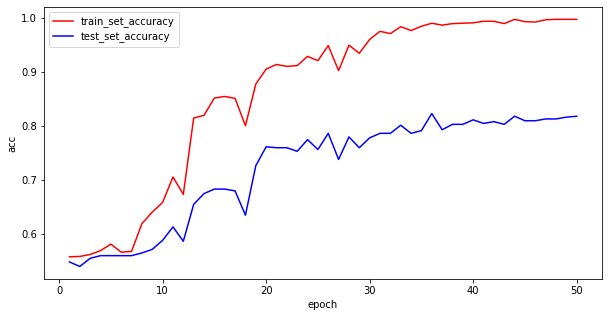

In [31]:
df_lstm=pd.DataFrame(train_test_acc,columns=['train_acc','test_acc'])
epoch=np.arange(1,len(df_lstm)+1)
df_lstm.index=epoch
print(df_lstm)
plt.figure(figsize=(10,5))
plt.plot(epoch,df_lstm['train_acc'],c='r',label='train_set_accuracy')
plt.plot(epoch,df_lstm['test_acc'],c='b',label='test_set_accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()